In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import keras
from keras import layers
from keras import models
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

plt.rcParams["figure.figsize"] = (20,8)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Предобработка данных

In [4]:
# Сцепляем эксельники в один датафрейм
df = pd.read_excel('/content/NLP_Task.xlsx', index_col = 'Unnamed: 0')
df_2 = pd.read_excel('/content/NLP_Task_2.xlsx', index_col = 'Unnamed: 0')
df_3 = pd.read_excel('/content/NLP_Task_3.xlsx', index_col = 'Unnamed: 0')

df = df.append(df_2).append(df_3)
df.index = list(range(4978))
df

,Review,Score
0,опыт взаимодействие с разный банк более год са...,1
1,обратиться в банк в отделение в нижний новгоро...,1
2,у банк открытие быть продукт виртуальный котор...,1
3,добрый время сутки хотеть поделиться свой опыт...,1
4,в период всеобщий ажиотаж и паника из за санкц...,1
...,...,...
4973,цб рф генеральный прокуратура и иной орган кот...,0
4974,смотреть по отзыв тут уже много такой но я пря...,0
4975,февраль заказать денежный средство валюта на м...,0
4976,иметь задолженность по кредитный карта долг пр...,0


In [5]:
review_max_length = 0

for i in df.Review:
  if len(i) > review_max_length:
    review_max_length = len(i)

print('Максимальная длина отзыва:', review_max_length)
print('Количество отзывов в датасете:', df.shape[0])

Максимальная длина отзыва: 3468
Количество отзывов в датасете: 4978


In [6]:
# Избавимся от стоп-слов
stop_words = stopwords.words('russian')

def clean_stop_words(text):
  text = word_tokenize(text)
  text = [word for word in text if word not in stop_words]
  return ' '.join(text)

df['Review'] = df['Review'].apply(lambda x: clean_stop_words(x))

review_max_length = 0

for i in df.Review:
  if len(i) > review_max_length:
    review_max_length = len(i)

print('Максимальная длина отзыва:', review_max_length)
print('Количество отзывов в датасете:', df.shape[0])

Максимальная длина отзыва: 2825
Количество отзывов в датасете: 4978


In [7]:
df_final = df.sample(frac=1).reset_index(drop=True)
df_final

,Review,Score
0,являться клиент банк давно размещать вклад нед...,1
1,пытаться осуществить платеж долл сша внутри вт...,0
2,крайне рекомендовать весь иметь счет тинькофф ...,0
3,связываться мтс банк кредитный карта открыть н...,0
4,плановый дата погашение минимальный платеж сум...,0
...,...,...
4973,спасибо сотрудник банк пользоваться карта халв...,1
4974,здравствуйте являться первый год клиент банк п...,1
4975,хотеть поблагодарить сотрудник мтс банк отделе...,1
4976,небольшой история сбер мочь кидать помнить ука...,0


# Моделирование

In [6]:
# Строим нейросеть
def neural_network():
  model = models.Sequential()
  model.add(layers.Embedding(1000, 128, input_length = 100))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dense(128, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

def logistic_regression():
  model = LogisticRegression(penalty = 'l2', C = 1e-3)
  return model

def random_forest():
  model = RandomForestClassifier(criterion = 'entropy')
  return model

def support_vector_machine():
  model = LinearSVC(penalty = 'l2', C = 1e-3)
  return model

def gradient_boosting():
  model = xgb.XGBClassifier(verbosity = 0)
  return model

X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

folds = StratifiedKFold(n_splits = 10)
accuracy = []

for train_index, val_index in folds.split(X, y):

  # Создаем тренировочные и тестовые датасеты
  X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

  # Обучаем токенизатор из слов тренировочного набора
  tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index

  # Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
  X_train = tokenizer.texts_to_sequences(X_train)
  X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
  X_val = tokenizer.texts_to_sequences(X_val)
  X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

  # Обучаем сеть и проверям точность
  nn = neural_network()
  nn.fit(X_train, y_train, epochs = 7, batch_size = 64, verbose = 0)
  nn_score = nn.evaluate(X_val, y_val, batch_size = 64, verbose = 0)[1]

  lr = logistic_regression().fit(X_train, y_train)
  lr_score = lr.score(X_val, y_val)

  rf = random_forest().fit(X_train, y_train)
  rf_score = accuracy_score(rf.predict(X_val), y_val)

  svm = support_vector_machine().fit(X_train, y_train)
  svm_score = svm.score(X_val, y_val)

  gb = gradient_boosting().fit(X_train, y_train)
  gb_score = accuracy_score([round(value) for value in gb.predict(X_val)], y_val)

  accuracy.append([nn_score, lr_score, rf_score, svm_score, gb_score])
  
accuracy_df = pd.DataFrame(accuracy, columns = ['NN', 'LR', 'RF', 'SVM', 'XGB'])
accuracy_df

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

,NN,LR,RF,SVM,XGB
0,0.928889,0.646667,0.671111,0.500000,0.697778
1,0.917778,0.624444,0.680000,0.531111,0.668889
2,0.944444,0.628889,0.646667,0.573333,0.675556
3,0.935556,0.604444,0.635556,0.475556,0.682222
4,0.928889,0.602222,0.666667,0.551111,0.637778
5,0.926667,0.660000,0.666667,0.515556,0.675556
6,0.937778,0.637778,0.633333,0.508889,0.628889
7,0.924444,0.628889,0.666667,0.597778,0.671111
8,0.926667,0.637778,0.655556,0.531111,0.660000
9,0.915556,0.622222,0.637778,0.577778,0.637778


# Нейросеть

In [7]:
# Нейронная сеть
model = models.Sequential()
model.add(layers.Embedding(1000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

folds = StratifiedKFold(n_splits = 5)
full_history = []

for train_index, val_index in folds.split(X, y):

  # Создаем тренировочные и тестовые датасеты
  X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

  # Обучаем токенизатор из слов тренировочного набора
  tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index

  # Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
  X_train = tokenizer.texts_to_sequences(X_train)
  X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
  X_val = tokenizer.texts_to_sequences(X_val)
  X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

  # Обучаем сеть и проверям точность
  history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 7, batch_size = 64, verbose = 0)
  full_history.append(pd.DataFrame(history.history))

In [8]:
full_history_df = full_history[0]

for i in full_history[1:]:
  full_history_df += i

full_history_df /= len(full_history)
full_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.596418,0.733611,0.449448,0.802667
1,0.368326,0.846167,0.337769,0.857111
2,0.274725,0.889722,0.281433,0.888222
3,0.224653,0.913278,0.253203,0.902000
4,0.193100,0.927278,0.242282,0.907778
5,0.170285,0.938222,0.233288,0.911778
6,0.152304,0.946722,0.229464,0.913333


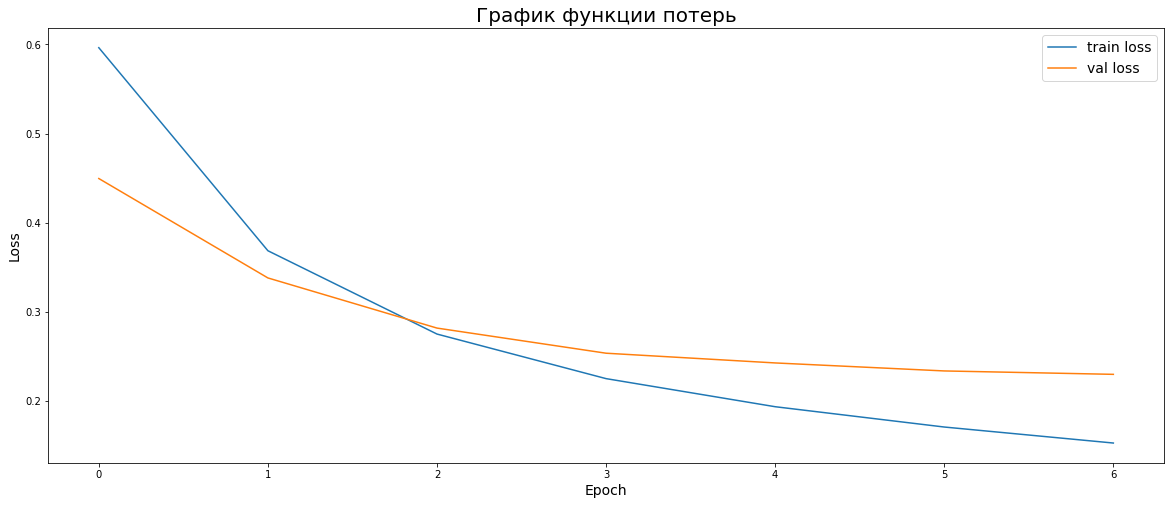

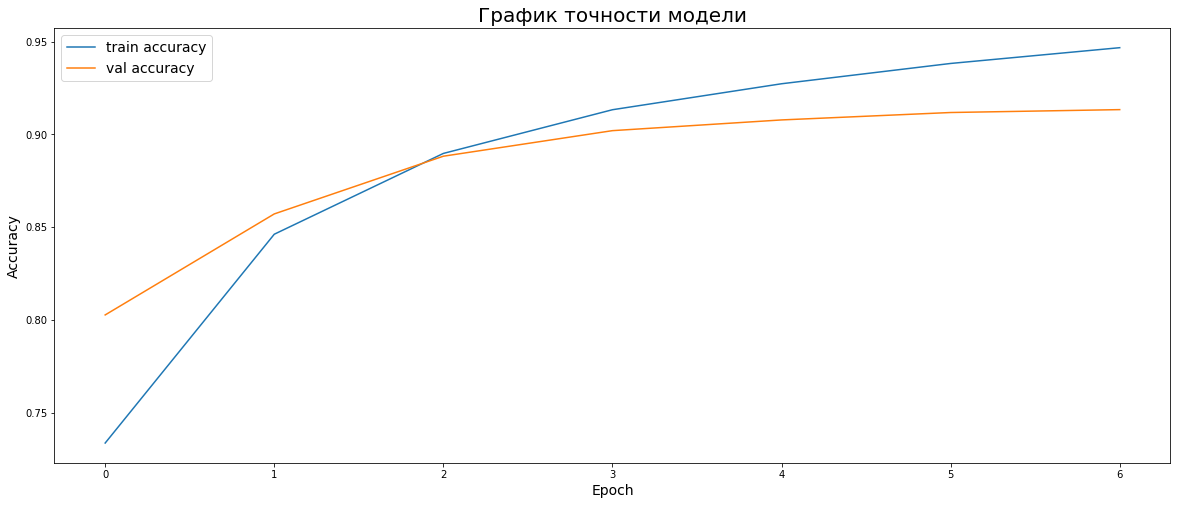

In [11]:
plt.plot(full_history_df.loss, label = 'train loss')
plt.plot(full_history_df.val_loss, label = 'val loss')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.title('График функции потерь', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

plt.plot(full_history_df.accuracy, label = 'train accuracy')
plt.plot(full_history_df.val_accuracy, label = 'val accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('График точности модели', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

In [12]:
X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

# Обучаем токенизатор из слов тренировочного набора
tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(1000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.9331
[0.17862868309020996, 0.9330543875694275]


In [30]:
# Обучаем токенизатор из слов тренировочного набора
X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 2ms/step - loss: 0.1733 - accuracy: 0.9414
[0.17330899834632874, 0.9414225816726685]


In [31]:
# Обучаем токенизатор из слов тренировочного набора
X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 1000, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 1000, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 1000))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 9ms/step - loss: 0.2707 - accuracy: 0.9268
[0.2707040011882782, 0.926778256893158]


In [32]:
# Обучаем токенизатор из слов тренировочного набора
X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 2ms/step - loss: 0.2472 - accuracy: 0.9184
[0.24723631143569946, 0.918410062789917]


In [42]:
# Обучаем токенизатор из слов тренировочного набора
X = np.array(df_final['Review'][:4500])
y = np.array(df_final['Score'][:4500])

X_test = np.array(df_final['Review'][4500:])
y_test = np.array(df_final['Score'][4500:])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 2, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9435
[0.17698730528354645, 0.9435146450996399]


In [45]:
df_final['Review'][4500]

'просто безобразный сервис альф треветь неделя мочь поменять время вылет звонить каждый день весь бесполезный сообщение обрабатываться оператор выслушивать ничто помогать помочь решить проблема бояться закончиться билет большой пользоваться услуга намерен аэрофлот билет поменять мочь нужный бесполезный сервис'

In [46]:
model.predict(X_test)[0]

array([0.05119932], dtype=float32)

In [47]:
df_final['Review'][4510]

'пользоваться услуга банк год именно карта рассрочка халва обращаться чат банк март ов ответить весь вопрос разва рнуто большой компетентный сотрудник совкомбанк сожаление попадаться хороший сотрудник банковский сфера спасибо'

In [48]:
model.predict(X_test)[10]

array([0.98791325], dtype=float32)

In [3]:
test = [
        'Отличный банк пользоваться год спасибо хороший работа',
        'Ужасный обслуживание ожидать нормальный сервис получить параша',
        'Принцип неплохой банк есть недостаток классный дизайн мочь рекомендовать друзья'
]

test_answers = [1, 0, 1]

test_df = pd.DataFrame({'Review': test, 'Score': test_answers})
test_df

,Review,Score
0,Отличный банк пользоваться год спасибо хороший...,1
1,Ужасный обслуживание ожидать нормальный сервис...,0
2,Принцип неплохой банк есть недостаток классный...,1


In [8]:
# Обучаем токенизатор из слов тренировочного набора
X = np.array(df_final['Review'])
y = np.array(df_final['Score'])

X_test = np.array(test_df['Review'])
y_test = np.array(test_df['Score'])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

# Токенизируем наборы, используя паддинг и ограничивая количество признаков в 100 слов для каждого наблюдения
X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.predict(X_test))

[[0.96657044]
 [0.4541142 ]
 [0.7254069 ]]
